<img src="https://j.gifs.com/vO2k6P.gif" alt="Indiana Jones Plane Flying Gif"></img>

# Great Circle Arcs and Path

---

## Overview

Imagine you are on a plane flying from Cario to Hong Kong. As a passenger, the plane appears to travel a straight path from one airport to the next. However, in reality, as the plane travels it actually curves along the surface of Earth held down by the gravity of the planet.

The "straight line" has become an arc connecting Cario and Hong Kong on a map. This arc is a great circle arc, just one small subsection of the great circle path.

1. Distance between Points on a Great Circle Arc
1. Convert Spherical Distance to Degrees
1. Determine the Bearing of a Great Circle Arc
1. Generate a Great Circle Arc with Intermediate Points
1. Determine the Midpoint of a Great Circle Arc
1. Generate a Great Circle Path
1. Determine an Antipodal Point

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Numpy](https://foundations.projectpythia.org/core/numpy/) | Necessary | Used to work with large arrays |
| [Pandas](https://foundations.projectpythia.org/core/pandas) | Necessary | Used to read in and organize data (in particular dataframes) |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy) | Helpful | Will be used for adding maps to plotting |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib/) | Helpful | Will be used for plotting |

- **Time to learn**: 40 minutes

---

## Imports

To begin, let's import the packages we will need in this notebook and collect the list of locations coordinates

In [22]:
import pandas as pd       # reading in data for location information from text file
import numpy as np        # working with arrays, vectors, cross/dot products, and radians

from pyproj import Geod   # working with the Earth as an ellipsod (WGS-84)
import geopy.distance     # working with the Earth as an ellipsod (WGS-84)

import matplotlib.pyplot as plt    # Plotting a figure
from cartopy import crs as ccrs, feature as cfeature  # Add World Map to Plot

In [2]:
# Get the coordinates for locations with all coordinates
location_df = pd.read_csv("../location_full_coords.txt")
location_df = location_df.rename(columns=lambda x: x.strip()) # strip excess white space from column names and values
location_df.head()

,name,latitude,longitude,cart_x,cart_y,cart_z,rho,theta,phi,polar_x,polar_y,polar_z
0,arecibo,18.3441,-66.7527,2.389526e+06,-5.562495e+06,2.007347e+06,6378137.0,-1.165054,1.250631,-5.562495e+06,2.389526e+06,2.007347e+06
1,boulder,40.0150,-105.2705,-1.286558e+06,-4.712394e+06,4.101066e+06,6378137.0,1.304276,0.872403,-4.712394e+06,-1.286558e+06,4.101066e+06
2,boston,42.3601,-71.0589,1.529809e+06,-4.457769e+06,4.297512e+06,6378137.0,-1.240212,0.831473,-4.457769e+06,1.529809e+06,4.297512e+06
3,redwoods,41.4017,-124.0417,-2.678169e+06,-3.964322e+06,4.218080e+06,6378137.0,0.976657,0.848200,-3.964322e+06,-2.678169e+06,4.218080e+06
4,houston,29.5518,-95.0982,-4.930480e+05,-5.526456e+06,3.145762e+06,6378137.0,1.481816,1.055020,-5.526456e+06,-4.930480e+05,3.145762e+06


In [3]:
# Set index to the name column, this will make it easier to access each row
location_df.index = location_df["name"]
location_df.head()

,name,latitude,longitude,cart_x,cart_y,cart_z,rho,theta,phi,polar_x,polar_y,polar_z
name,,,,,,,,,,,,
arecibo,arecibo,18.3441,-66.7527,2.389526e+06,-5.562495e+06,2.007347e+06,6378137.0,-1.165054,1.250631,-5.562495e+06,2.389526e+06,2.007347e+06
boulder,boulder,40.0150,-105.2705,-1.286558e+06,-4.712394e+06,4.101066e+06,6378137.0,1.304276,0.872403,-4.712394e+06,-1.286558e+06,4.101066e+06
boston,boston,42.3601,-71.0589,1.529809e+06,-4.457769e+06,4.297512e+06,6378137.0,-1.240212,0.831473,-4.457769e+06,1.529809e+06,4.297512e+06
redwoods,redwoods,41.4017,-124.0417,-2.678169e+06,-3.964322e+06,4.218080e+06,6378137.0,0.976657,0.848200,-3.964322e+06,-2.678169e+06,4.218080e+06
houston,houston,29.5518,-95.0982,-4.930480e+05,-5.526456e+06,3.145762e+06,6378137.0,1.481816,1.055020,-5.526456e+06,-4.930480e+05,3.145762e+06


## Distance Between Points on a Great Circle Arc

We can determine the distance between two points A and B (for example, Cario and Hong Kong) both by hand mathematically and with Python packages like `pyproj` and `geopy`

### Determine Distance Between Points Mathematically via Unit Sphere

Unit sphere refers to a sphere with a radius of 1, for the purpose of this cookbook, when we are using a unit sphere to represent Earth, it is a perfect sphere that has been multiplied by 6378137 meters

First, to measure the distance between point A (latA, lonA) and point B (latB, lonB) on a unit sphere (radius = 1)

$$d=acos(sin(latA)*sin(latB)+cos(latA)*cos(latB)*cos(lonA-lonB))$$

Because of the translation when working with radians and degrees, there is a mathematically equivalent formula that works better when working with shorter distances (to produce less rounding errors):

$$d=2*asin(\sqrt{sin(\frac{latA-latB}{2})^2 + cos(latA)*cos(latB)*sin(\frac{lonA-lonB}{2})^2})$$

- [See more: Distance Between Points](https://edwilliams.org/avform147.htm#Dist)

We can now translate these equations for measuring the distance between two points (the great circle arc distance) into Python and multiply the result by the Earth's radius. 

These equations use a locations's latitude/longtiude coordinates, which we can access in a `pandas` dataframe with the name of the location and which coordinate type we would like, for example:

In [6]:
print(f"Boulder latitude: {location_df.loc["boulder", "latitude"]}")
print(f"Boulder longitude: {location_df.loc["boulder", "longitude"]}")

Boulder latitude: 40.015
Boulder longitude: -105.2705


Below, Equation 1 has become `distance_between_points_default` since this is the equation we will use for most equations, but Equation 2 has become `distance_between_points_small` for working with small distances that are less prone to rounding errors. We can call both equations to compare outputs to see how they are mathematically equivalent. By hand, Equation 1 is a faster calculation than Equation 2, but when working with Python both of these functions will run nearly as quickly.

In [7]:
def distance_between_points_default(start_point=None, end_point=None):
    earth_radius = 6378137  # meters
    latA = np.deg2rad(location_df.loc[start_point, "latitude"])
    lonA = np.deg2rad(location_df.loc[start_point, "longitude"])
    latB = np.deg2rad(location_df.loc[end_point, "latitude"])
    lonB = np.deg2rad(location_df.loc[end_point, "longitude"])

    distance_default = np.arccos(np.sin(latA)*np.sin(latB)+np.cos(latA)*np.cos(latB)*np.cos(lonA-lonB))
    return distance_default * earth_radius

In [8]:
def distance_between_points_small(start_point=None, end_point=None):
    earth_radius = 6378137  # meters
    latA = np.deg2rad(location_df.loc[start_point, "latitude"])
    lonA = np.deg2rad(location_df.loc[start_point, "longitude"])
    latB = np.deg2rad(location_df.loc[end_point, "latitude"])
    lonB = np.deg2rad(location_df.loc[end_point, "longitude"])

    distance_small = 2 * np.arcsin(np.sqrt((np.sin((latA-latB)/2))**2 + np.cos(latA)*np.cos(latB)*(np.sin((lonA-lonB)/2))**2))
    return distance_small * earth_radius

### Sidenote: Additional Formulas

While we will be focusing on Equation 1 and Equation 2 for our calculations in the future, there are even more methods to calculate the distance between points on a sphere. Each formula has different degrees of precision based on which ellipsoid or sphere is used:

##### Haversine Formula (TODO)

The Haversine Formula determines the great circle distance between two latitude/longtidue points on a sphere, originally conceived in the early 1800's. Haversine makes use of the central angle θ between two points, measured from the center of the sphere where:

$$θ = \frac{d}{r}$$

Where `d` is the distance between the two latitude/longitude coordinates on the spehre and `r` is the radius of the sphere. Then, to solve for the distance between the two points (`d`):

$$\text{difference in latitude} = (\text{latB} - \text{latA})$$
$$\text{difference in longitude} = (\text{lonB} - \text{lonA})$$

Where the difference in latitude (`dlat`) and longitude (`dlon`) can then be used to calculate:

$$a = sin(\frac{dlat}{2})^2 + cos(latA) * cos(latB) * sin(\frac{dlon}{2})^2$$
$$c = 2 * arcsin(min(1, sqrt(a)))$$
$$\text{haversine distance} = R * c$$

Where R is the radius of the Earth.

[See more](https://en.wikipedia.org/wiki/Haversine_formula)

See also: [reference](https://cs.nyu.edu/~visual/home/proj/tiger/gisfaq.html) (R.W. Sinnott, "Virtues of the Haversine", Sky and Telescope, vol. 68, no. 2, 1984, pg. 159) (TODO)

##### Vincenty's Formula (TODO)

Vincenty's formula is an interative method to calculate the distance between two points on the surface of a spheroid, which has the advantage that it assumpes that the Earth is not a perfect spehre. Instead, it assumes the Earth is an oblate spheroid, which can make it more accurate that typical great circle methods that assume the planet is a sphere

- Vincenty Sphere Great Circle Distance
- Vincenty Ellipsoid Great Circle Distance

[See more](https://en.wikipedia.org/wiki/Vincenty%27s_formulae)

##### Meeus Great Circle Distance

Meeus is a calculation for determining the distance between two points on an ellipsoid from J. Meeus _Astronomical Algorithms_ (1991, 2nd Edition, pg. 477) which is [used in R (`distMeeus`)](https://rdrr.io/cran/geosphere/man/distMeeus.html). This calculations includes input values for both the radius and the inverse flattening value (but still defaults to WGS-84)

##### Law of Cosines Great Circle Distance (TODO)

There is a method to use the law of cosines to determine the shortest distance between two points on a sphere, [which is used in R](https://www.rdocumentation.org/packages/geosphere/versions/1.5-20/topics/distCosine)


### Determine Distance Points via Python Package `pyproj`

While great circle distances can be determine mathematically, there are some Python packages that account for the fact that the Earth is not a perfect sphere that will be easier to work than relying entirely on the equations derived above. For example, `pyproj` treats the Earth as an ellipsoid, by default specifically `WGS-84`.

[WGS-84 is the World Geodetic System](https://en.wikipedia.org/wiki/World_Geodetic_System) and considered to be the current standard for geodesy and working with satellite. It is an geocentric and is consistent to within 1 meter around the globe.

To begin, let use use `pyproj` to set up an ellipsoid (`WGS-84`) that will represent the Earth.

In [27]:
def distance_pyproj(start_pt=None, end_pt=None):
    geodesic = Geod(ellps="WGS84") # setup ellipsoid

    # Return the distance between two points (for example, Boulder and Boston)
    _, _, distance_meter =  geodesic.inv(location_df.loc[start_pt, "longitude"],
                                         location_df.loc[start_pt, "latitude"],
                                         location_df.loc[end_pt, "longitude"],
                                         location_df.loc[end_pt, "latitude"])
    
    return distance_meter

In [28]:
# Find the distance between Boulder and Boston
distance_meter = distance_pyproj("boulder", "boston")
print(f"Distance between coordinates (ellipsoid)   = {distance_meter/1000} km")

Distance between coordinates (ellipsoid)   = 2862.5974799145215 km


That is much easier! We can compare `pyproj` to the output from the equations (1 and 2) that we calculated above:

In [29]:
distance_unit_sphere_default = distance_between_points_default("boulder", "boston")
print(f"Distance between coordinates (unit sphere) = {distance_unit_sphere_default/1000} km")
distance_unit_sphere_small = distance_between_points_small("boulder", "boston")
print(f"Distance between coordinates (unit sphere) = {distance_unit_sphere_small/1000} km")

Distance between coordinates (unit sphere) = 2858.532213639344 km
Distance between coordinates (unit sphere) = 2858.5322136393447 km


Both equations we calculated above slightly underestimate the distance between Boston and Boulder because they assume the Earth is a perfect sphere, `pyproj` accounts for ellipse.

## Convert Spherical Distance to Degrees

Sometimes when you are working with a map, you don't always just need a distance in meters or kilometers. We can also convert the distances calculated back into degrees as needed. To convert a distance from meters to degrees, we will assume that the great circle is on a unit sphere with a constant spherical radius of ~6371 km (mean radius of Earth).

Side note: The Python library `ObsPy` has a similar function built-in: [ObsPy `kilometer2degrees()`](https://docs.obspy.org/packages/autogen/obspy.geodetics.base.kilometer2degrees.html)

In [11]:
earth_radius = 6378.137 # km

def km_to_degree_distance(distance_km=None):
    return distance_km / (2 * earth_radius * np.pi / 360)

def degree_to_km_distance(distance_degree=None):
    return distance_degree * (2 * earth_radius * np.pi / 360)

In [15]:
# We can convert back and form between kilometers and degrees
print(f"300 km to degrees = {km_to_degree_distance(300)} degrees")
print(f"2.6949458523585643 degree to km = {degree_to_km_distance(2.6949458523585643)} km")

300 km to degrees = 2.6949458523585643 degrees
2.6949458523585643 degree to km = 300.0 km


## Determine the Bearing of a Great Circle Arc

Arcs are not just a distance, but a direction. Now, we can calculate the direction that an arc takes as it moves from Point A to Point B also known as the bearing.

### Determine the Bearing Mathematically via Unit Sphere

The bearing between between Point A (latA, lonA) and Point B (latB, lonB) on a unit sphere can be calculated as:

$$x = cos(latA) * sin(latB) - sin(latA) * cos(latB) * cos(lonB - lonA)$$
$$y = sin(lonB - lonA) * cos(latB)$$
$$θ = atan2(y, x)$$

- [Movable Type: Bearing](https://www.movable-type.co.uk/scripts/latlong.html#bearing)

This can be similarly converted to Python as:

In [16]:
def bearing_between_points_unit_sphere(start_point=None, end_point=None):
    latA = np.deg2rad(location_df.loc[start_point, "latitude"])
    lonA = np.deg2rad(location_df.loc[start_point, "longitude"])
    latB = np.deg2rad(location_df.loc[end_point, "latitude"])
    lonB = np.deg2rad(location_df.loc[end_point, "longitude"])

    x = np.cos(latA) * np.sin(latB) - np.sin(latA) * np.cos(latB) * np.cos(lonB - lonA)
    y = np.sin(lonB - lonA) * np.cos(latB)
    bearing = np.arctan2(y, x)
    return np.rad2deg(bearing) % 360

### Determine the Bearing via Python Package `pyproj`

`pyproj` can also use the same `geodesic.inv()` function to calculate bearing. However, `pyproj` includes both the foward and reverse bearing. Foward bearing refers to the bearing from Point A to Point B, while the reverse bearing is the bearing from Point B to Point A. The reverse bearing is returned as a negative angle, but it can also be calculated as the `Forward Bearing - 360`.

For example, to find the bearing from Boulder and Boston:

In [18]:
geodesic = Geod(ellps="WGS84")
fwd_bearing, rvs_bearing, _ =  geodesic.inv(location_df.loc["boulder", "longitude"],
                                             location_df.loc["boulder", "latitude"],
                                             location_df.loc["boston", "longitude"],
                                             location_df.loc["boston", "latitude"])
print(f"Foward Bearing: {fwd_bearing}")
print(f"Reverse Bearing: {rvs_bearing} ({rvs_bearing%360})")

Foward Bearing: 73.51048829569022
Reverse Bearing: -83.57035585674933 (276.4296441432507)


When refering to bearing however, it is typically assumed to be refering to the foward bearing, so we will use the function below as we move foward.

In [19]:
def bearing_between_points_ellps(start_point=None, end_point=None):
    geodesic = Geod(ellps="WGS84")
    fwd_bearing, _, _ =  geodesic.inv(location_df.loc[start_point, "longitude"],
                                        location_df.loc[start_point, "latitude"],
                                        location_df.loc[end_point, "longitude"],
                                        location_df.loc[end_point, "latitude"])
    return fwd_bearing

Because of the slightly flattened shape of an ellipsoid compared to a sphere, the bearing can also vary depending on if you are calculating bearing on a unit sphere or a ellipsoid:

In [20]:
### Compare Unit Sphere and Ellipsoid
beaing_ellps = bearing_between_points_ellps("boulder", "boston")
print(f"forward bearing between coordinates (ellipsoid)   = {beaing_ellps} Degrees")
bearing_us = bearing_between_points_unit_sphere("boulder", "boston")
print(f"forward bearing between coordinates (unit sphere) = {bearing_us} Degrees")

forward bearing between coordinates (ellipsoid)   = 73.51048829569022 Degrees
forward bearing between coordinates (unit sphere) = 73.49180375272644 Degrees


## Generating a Great Circle Arc with Intermediates Points

Now we have calculated both the length of a great circle arc as well as its bearing. Now we can begin to add additional points along the arc. These intermediate points will lie along the great circle arc and can be calculated as the fractional distance laong the arc (for example, a point for every 10th of the arc).

### Determine Intermediate Points Mathemetically via Unit Sphere (Fractional Distance)

Along a unit sphere, we can calculate each intermediate point as a fractional distance along the arc. We can determine the points as a given fraction of a distance (`d`) between a starting points A (latA, lonA) and the final point B (latB, lonB) where `f` is a fraction along the great circle arc. As a result, Point A is at`f=0` and Point B sits at`f=1` along the arc.

> Note: The points must not lie on exact opposite sides of a sphere (antipodal), otherwise, the path is undefined because f=0=1

Where, antipodal is defined by:
$$latA + latB = 0$$
$$abs(lonA - lonB) = pi$$

Where the distance between two points is the angular distance:

$$d = \frac{\text{total distance of arc}}{\text{earth's radius}}$$

The intermediate points (lat, lon) along a given path starting point to end point:

$$A = sin(\frac{(1-f) * d}{sin(d)}$$
$$B = \frac{sin(f*d)}{sin(d)}$$
$$x = A * cos(latA) * cos(lonA) + B * cos(latB) * cos(lonB)$$
$$y = A * cos(latA) * sin(lonA) + B * cos(latB) * sin(lonB)$$
$$z = A * sin(latA) + B * sin(latB)$$
$$lat = atan2(z, \sqrt{x^2 + y^2})$$
$$lon = atan2(y, x)$$

- [Ed Williams: Intermediate Points on a Great Circle](https://edwilliams.org/avform147.htm#Intermediate)
- [Moveable Type: Intermediate Point](https://www.movable-type.co.uk/scripts/latlong.html#intermediate-point)

Let's translate this math into Python code:

In [86]:
def intermediate_points(start_point=None, end_point=None,
                        fraction=None, distance=None):
    # Calculates the position of an intermediate point based on its fractional position along an arc defined from Point A to Point B
    earth_radius = 6378137  # meters
    total_distance = distance / earth_radius
    latA = np.deg2rad(location_df.loc[start_point, "latitude"])
    lonA = np.deg2rad(location_df.loc[start_point, "longitude"])
    latB = np.deg2rad(location_df.loc[end_point, "latitude"])
    lonB = np.deg2rad(location_df.loc[end_point, "longitude"])

    A = np.sin((1-fraction) * total_distance) / np.sin(total_distance)
    B = np.sin(fraction * total_distance) / np.sin(total_distance)
    x = (A * np.cos(latA) * np.cos(lonA)) + (B * np.cos(latB) * np.cos(lonB))
    y = (A * np.cos(latA) * np.sin(lonA)) + (B * np.cos(latB) * np.sin(lonB))
    z = (A * np.sin(latA)) + (B * np.sin(latB))
    lat = np.arctan2(z, np.sqrt(x**2 + y**2))
    lon = np.arctan2(y, x)
    return (float(np.rad2deg(lat)), float(np.rad2deg(lon)))

def calculate_intermediate_pts(start_point=None, end_point=None,
                               fraction=None, total_distance_meter=None):
    # returns a list of intermediate points along the arc seperated by a specific fraction
    fractions = np.arange(0, 1+fraction, fraction)
    intermediate_lat_lon = []
    for fractional in fractions:
        intermediate_pts = intermediate_points(start_point, end_point,
                                                fractional, total_distance_meter)
        intermediate_lat_lon.append(intermediate_pts)
    return intermediate_lat_lon

### Determine Intermediate Points via Python Package `pyproj` and `geopy`

However, there is a strong advantage when you the Python libraries `pyproj` and `geopy`. Not only can you use an ellipsoid instead of a sphere, you can also interpolate points along an arc in additional ways:

- A fractional distance laong the arc (for example, a point for every 10th of the arc)
- A known distance along the arc (for example, a point ever 100 meters)
- An equal amount of points (for example, adding 6 intermediate points which are equally spaced along the arc)

Below you will see how we can use one function `interpolate_points_along_gc` to be able to solve for all three possible types of intermediate points. The function will use both the starting and ending coordinates (Point A to Point B) and a distance you'd like to have between each point.

In [51]:
def interpolate_points_along_gc(lat_start,
                                lon_start,
                                lat_end,
                                lon_end,
                                distance_between_points_meter): 
    # Interpolate intermediate points along an arc wtih a given distance between each point
    lat_lon_points = [(float(lat_start), float(lon_start))]
    
    # move to next point when distance between points is less than the equal distance
    move_to_next_point = True
    while(move_to_next_point):
        forward_bearing, _, distance_meters = geodesic.inv(lon_start,
                                                            lat_start, 
                                                            lon_end,
                                                            lat_end)
        if distance_meters < distance_between_points_meter:
            # ends before overshooting
            move_to_next_point = False
        else:
            start_point = geopy.Point(lat_start, lon_start)
            distance_to_move = geopy.distance.distance(
                            kilometers=distance_between_points_meter /
                            1000)  # distance to move towards the next point
            final_position = distance_to_move.destination(
                            start_point, bearing=forward_bearing)
            lat_lon_points.append((float(final_position.latitude), float(final_position.longitude)))
            # new starting position is newly found end position
            lon_start, lat_start = final_position.longitude, final_position.latitude
    lat_lon_points.append((float(lat_end), float(lon_end)))
    return lat_lon_points

#### Interpolate with N Total Equally Spaced Points

Imagine we are flying a plane with a set amount of gas and will need to make 10 stops along our path to refuel from Boulder to Boston. If we need to stop 10 times (imagine that there is a refueling station wherever we stop) then we can interpolate along our path with 10 additional points

In [53]:
n_total_points = 10 # total points (n points)

# Calculate the distance between Point A (Boulder) and Point B (Boston)
distance_meter = distance_pyproj("boulder", "boston")
print(f"Total distance from Boulder to Boston = {distance_meter/1000} km")

distance_between_points_meter = distance_meter / (n_total_points + 1)
print(f"Each of the {n_total_points} points will be separated by {distance_between_points_meter} meters ({distance_between_points_meter/1000} km)")

Total distance from Boulder to Boston = 2862.5974799145215 km
Each of the 10 points will be separated by 260236.13453768377 meters (260.23613453768377 km)


Excellent! Now that we know the distances between each of the 10 equally spaced points we can use `interpolate_points_along_gc` to find a list of interpolated points. Note that will be 12 total points, 10 intermediate points and 1 for each the starting and ending position.

In [55]:
lat_start, lon_start = location_df.loc[["boulder"]]["latitude"].iloc[0], location_df.loc[["boulder"]]["longitude"].iloc[0]
lat_end, lon_end = location_df.loc[["boston"]]["latitude"].iloc[0], location_df.loc[["boston"]]["longitude"].iloc[0]

interpolated_pts = interpolate_points_along_gc(lat_start,
                                          lon_start,
                                          lat_end,
                                          lon_end,
                                          distance_between_points_meter)
print(f"{len(interpolated_pts)} Total Points")
print(f"List of Interpolated Points:\n{interpolated_pts}")

12 Total Points
List of Interpolated Points:
[(40.015, -105.2705), (40.64283438472448, -102.32002071588883), (41.19386139956729, -99.31719425393653), (41.665293789240074, -96.2672998277903), (42.05464865958041, -93.17653047007545), (42.35980367525435, -90.05192021556942), (42.579048241302566, -86.9012334462751), (42.71112689737456, -83.73281874084786), (42.75527239726804, -80.5554326250441), (42.711226442193585, -77.37804142647055), (42.579246749547636, -74.20961159223961), (42.3601, -71.0589)]


### Plot Arcs as Points on a World Map

The easiest way to understand how these interpolated points will look along an arc is to plot them. To be able to reuse this plotting structure in multiple examples below we will encompass the plot into a simple function which takes in a string for the plot's title and a list of coordinates (which will include Point A at the start and Point B at the end)

In [56]:
def plot_coordinate(lst_of_coords=None, title=None):
    # Set up world map plot on the United States
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    lon_west, lon_east, lat_south, lat_north = -130, -60, 20, 60
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.STATES, edgecolor="black")
    
    # Plot Latitude/Longitude Coordinates
    longitudes = [x[1] for x in lst_of_coords] # longitude
    latitudes = [x[0] for x in lst_of_coords] # latitude
    plt.plot(longitudes, latitudes)
    plt.scatter(longitudes, latitudes)
    
    # Setup Axis Limits and Title/Labels
    plt.title(title)
    plt.show()

Now, let's plot those 10 equally spaced points!

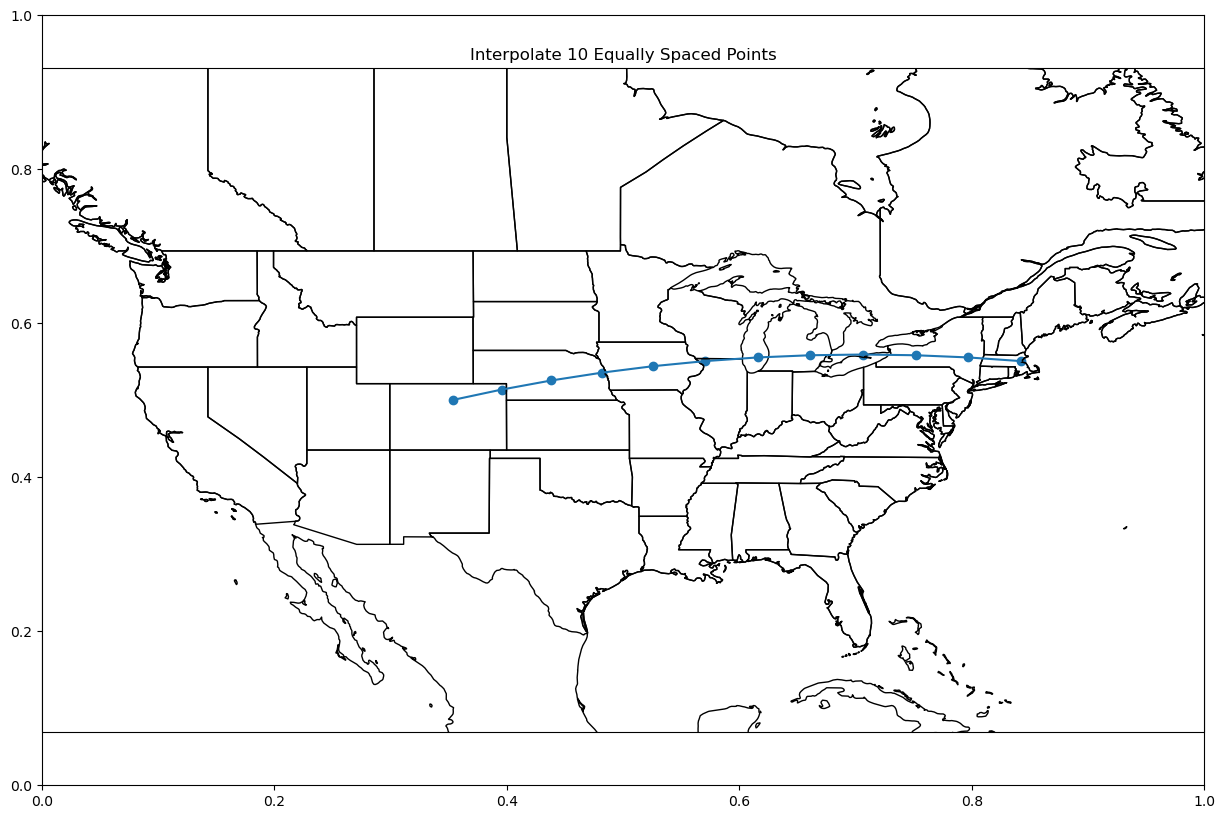

In [58]:
plot_coordinate(intermediate_geodesic,
                title=f"Interpolate {n_total_points} Equally Spaced Points")

Looking good! Alright, let's move along to interpolate based on a known distance

#### Interpolate every N meters

A plane has a fuel tank that can hold a known amount of gas, what if instead we wanted to known how far we need to refuel, but now in meters? Let's say we hold a gas tank that can hold enough fuel to get 112 km, how many times will we need to stop and where along would those stops appear?

In [60]:
distance_between_points_meter = 112000 # 122.0 km
print(f"Each point will be separated by {distance_between_points_meter} meters ({distance_between_points_meter/1000} km)")

Each point will be separated by 112000 meters (112.0 km)


In [62]:
lat_start, lon_start = location_df.loc["boulder", "latitude"], location_df.loc["boulder", "longitude"]
lat_end, lon_end = location_df.loc["boston", "latitude"], location_df.loc["boston", "longitude"]

interpolated_pts = interpolate_points_along_gc(lat_start,
                                          lon_start,
                                          lat_end,
                                          lon_end,
                                          distance_between_points_meter)
print(f"{len(interpolated_pts)} Total Points")
print(f"List of Interpolated Points:\n{interpolated_pts}")

27 Total Points
List of Interpolated Points:
[(40.015, -105.2705), (40.29443152420481, -104.00739372929635), (40.55994883031889, -102.73410083358552), (40.811312209497714, -101.45097760323463), (41.04829010633232, -100.15841313140038), (41.27065999040772, -98.8568290209118), (41.47820922569627, -97.54667886388195), (41.67073593071231, -96.22844748540258), (41.848049822017195, -94.90264994540797), (42.00997303342117, -93.56983029584387), (42.156340903095064, -92.23056009359964), (42.287002720790326, -90.88543667319323), (42.40182242747838, -89.53508118686946), (42.50067925996674, -88.1801364234981), (42.583468333429785, -86.82126442135142), (42.65010115530707, -85.45914389340653), (42.700506064664665, -84.09446748716023), (42.73462859187762, -82.72793890397021), (42.75243173435998, -81.36026990555973), (42.75389614502746, -79.99217723746453), (42.73902023120852, -78.62437950079696), (42.707820162798164, -77.25759400470386), (42.66032978955507, -75.89253363227026), (42.596600468550456, -

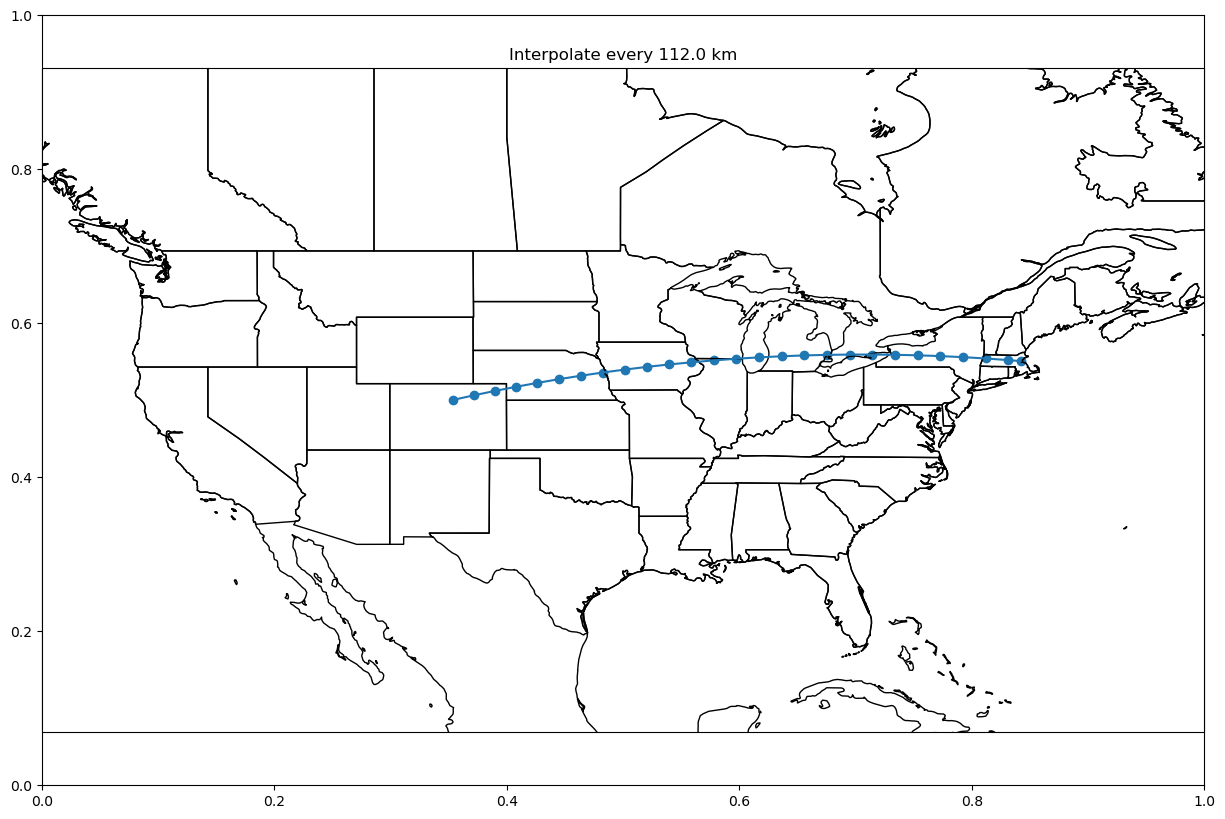

In [64]:
plot_coordinate(interpolated_pts,
                title=f"Interpolate every {distance_between_points_meter/1000} km")

That's a lot of stop! Ok, now we can return to a familiar system. We can use this same system to also determine fractional distances as well!

#### Interpolate a fractional distance along arc

[Above](#determine-intermediate-points-mathemetically-via-unit-sphere-fractional-distance) we calculated how to find intermediate points as a fractional distance along an arc. We can now return to this, but with the advantages of using an ellipsoid! Let's try this method and interpolate points every 10th of an arc.

In [65]:
fraction = 1/10

In [67]:
distance_between_points_meter = fraction * distance_meter
print(f"Interpolate for every {fraction} of the arc")
print(f"Each point will be separated by {distance_between_points_meter} meters ({distance_between_points_meter/1000} km)")

Interpolate for every 0.1 of the arc
Each point will be separated by 286259.74799145217 meters (286.2597479914522 km)


In [71]:
lat_start, lon_start = location_df.loc["boulder", "latitude"], location_df.loc["boulder", "longitude"]
lat_end, lon_end = location_df.loc["boston", "latitude"], location_df.loc["boston", "longitude"]

interpolated_pts = interpolate_points_along_gc(lat_start,
                                          lon_start,
                                          lat_end,
                                          lon_end,
                                          distance_between_points_meter)
print(f"{len(interpolated_pts)} Total Points")
print(f"List of Interpolated Points:\n{interpolated_pts}")

11 Total Points
List of Interpolated Points:
[(40.015, -105.2705), (40.70144152851926, -102.0220139666611), (41.29459964930597, -98.7107954391427), (41.790822409112124, -95.34405626799516), (42.18692017366623, -91.93032741511365), (42.4802543416051, -88.47932636547252), (42.66881568690329, -85.00175846666659), (42.75128706952139, -81.50905885116296), (42.72708599453554, -78.01308797522954), (42.59638380227174, -74.52579917182065), (42.3601, -71.0589)]


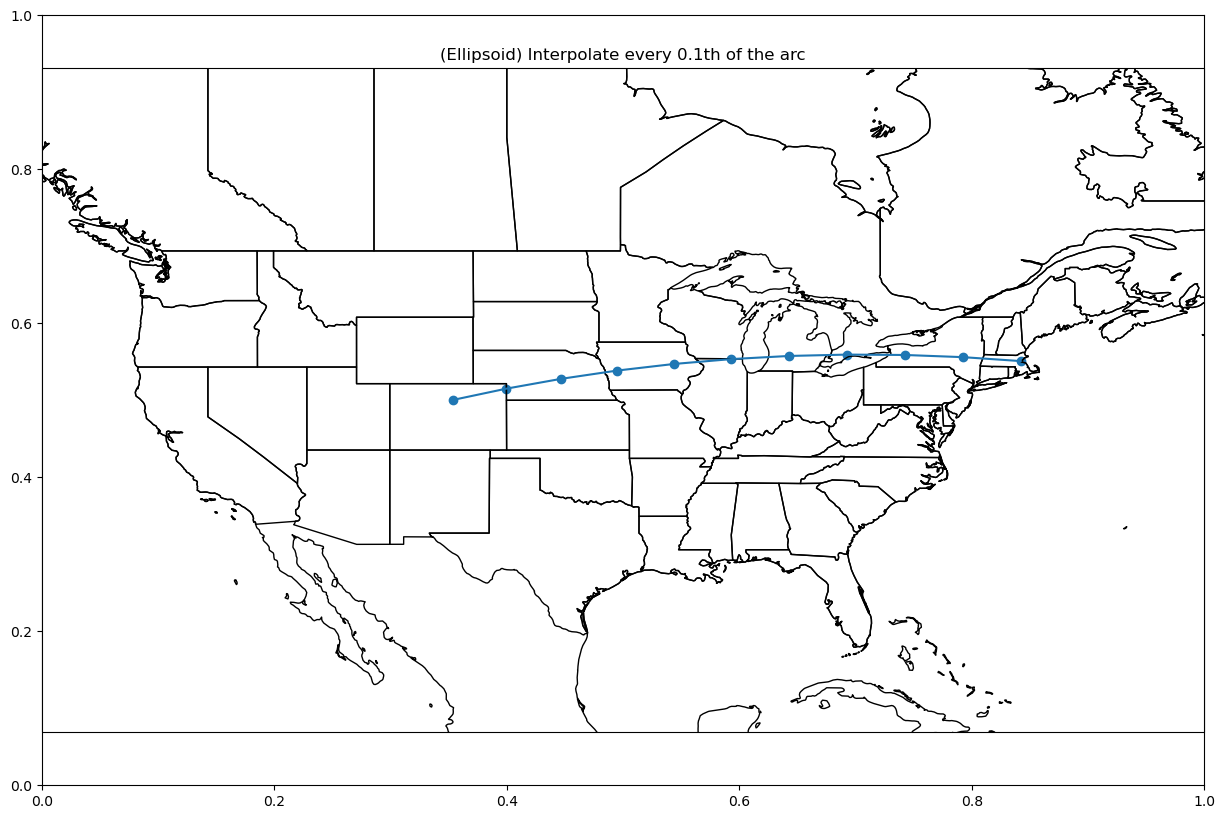

In [72]:
plot_coordinate(interpolated_pts,
                title=f"(Ellipsoid) Interpolate every {fraction}th of the arc")

We can now compare both the ellipsoid and spherical model. First, let's plot the same fractional distance along the unit sphere:

In [74]:
distance_unit_sphere_default = distance_between_points_default("boulder", "boston")
intermediate_unit_sphere = calculate_intermediate_pts("boulder", "boston",
                                               fraction, distance_unit_sphere_default)
print(f"{len(intermediate_unit_sphere)} Total Points")
print(f"List of Interpolated Points:\n{intermediate_unit_sphere}")

11 Total Points
List of Interpolated Points:
[(np.float64(40.015), np.float64(-105.2705)), (np.float64(40.69956840796515), np.float64(-102.0224051615289)), (np.float64(41.291305596308824), np.float64(-98.71150732723615)), (np.float64(41.786544424077), np.float64(-95.3450112546059)), (np.float64(42.1820804843035), np.float64(-91.93144054027105)), (np.float64(42.475261312703864), np.float64(-88.48050569778584)), (np.float64(42.66406520473303), np.float64(-85.00290620334833)), (np.float64(42.74716436193266), np.float64(-81.51007310432796)), (np.float64(42.723967826794556), np.float64(-78.01386515980239)), (np.float64(42.59464096704978), np.float64(-74.52623685097386)), (np.float64(42.3601), np.float64(-71.0589))]


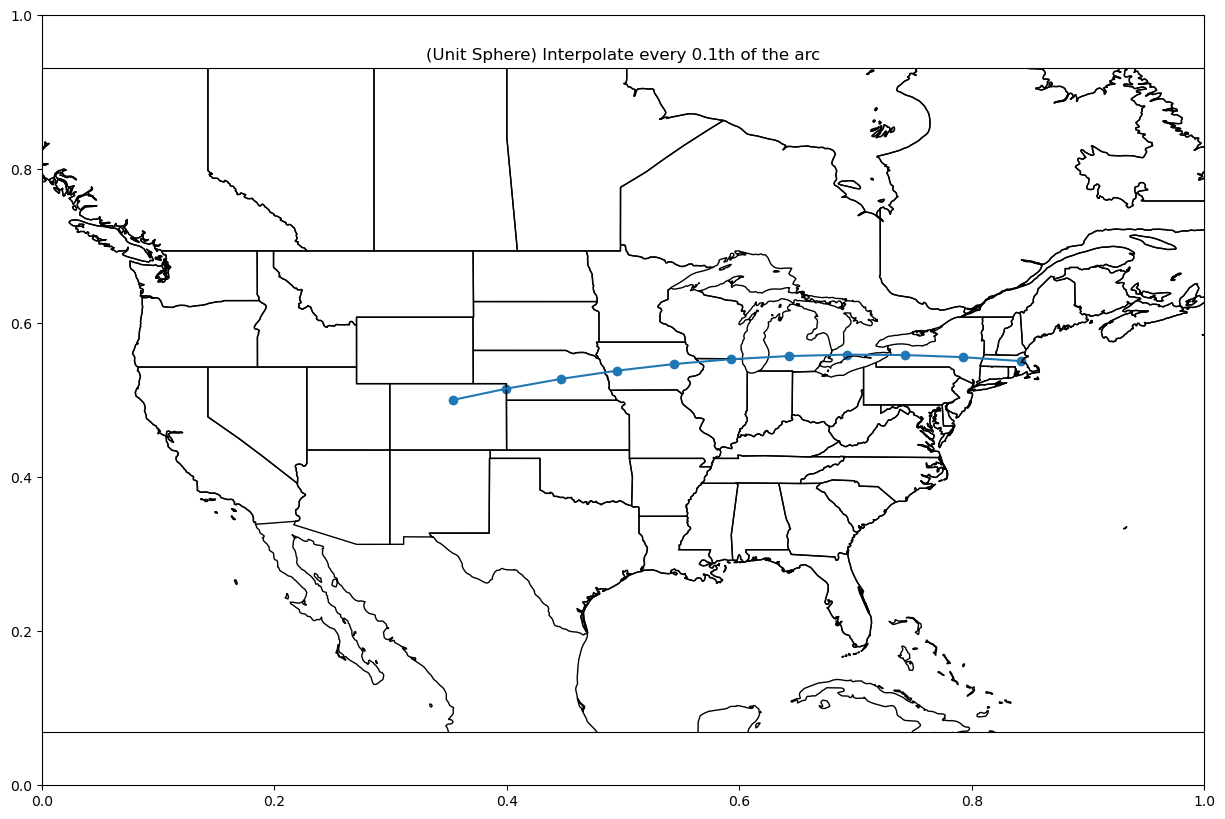

In [75]:
plot_coordinate(intermediate_unit_sphere,
                title=f"(Unit Sphere) Interpolate every {fraction}th of the arc")

The difference between the ellipsoid and the sphere will become more apparently as intermediate points along the arc are shifted to new positions based on whether or not it is a sphere.

In [80]:
# Compare Unit Sphere and Ellipsoid
for i in range(len(interpolated_pts)):
    _, _, distance_m = geodesic.inv(interpolated_pts[i][0], interpolated_pts[i][1],
                                   intermediate_unit_sphere[i][0], intermediate_unit_sphere[i][1])
    if np.isnan(distance_m): distance_m = 0
    print(f"Difference in distance between ellipsoid/unit sphere at point {i}: {distance_m} meters")

Difference in distance between ellipsoid/unit sphere at point 0: 0 meters
Difference in distance between ellipsoid/unit sphere at point 1: 0 meters
Difference in distance between ellipsoid/unit sphere at point 2: 0 meters
Difference in distance between ellipsoid/unit sphere at point 3: 0 meters
Difference in distance between ellipsoid/unit sphere at point 4: 0 meters
Difference in distance between ellipsoid/unit sphere at point 5: 132.55154860348821 meters
Difference in distance between ellipsoid/unit sphere at point 6: 136.26443374199349 meters
Difference in distance between ellipsoid/unit sphere at point 7: 132.0972186842191 meters
Difference in distance between ellipsoid/unit sphere at point 8: 112.95654352480192 meters
Difference in distance between ellipsoid/unit sphere at point 9: 71.29186326482345 meters
Difference in distance between ellipsoid/unit sphere at point 10: 0.0 meters


## Determine the Midpoint of a Great Circle Arc

The advantage of using fractional distances it is make it simple to find the midpoint along the arc. The midpoint of an arc can be determined as a fractional distance along an arc where `f = 0.5`.

In [82]:
distance_meter = distance_pyproj("boulder", "boston")

# Distance along the arc where the midpoint lies:
midpoint = distance_meter / 2

In [84]:
lat_start, lon_start = location_df.loc["boulder", "latitude"], location_df.loc["boulder", "longitude"]
lat_end, lon_end = location_df.loc["boston", "latitude"], location_df.loc["boston", "longitude"]

interpolated_pts = interpolate_points_along_gc(lat_start,
                                          lon_start,
                                          lat_end,
                                          lon_end,
                                          midpoint)
print(f"{len(interpolated_pts)} Total Points")
print(f"List of Interpolated Points:\n{interpolated_pts}")
print(f"Midpoint = {intermediate_geodesic[1]}")

3 Total Points
List of Interpolated Points:
[(40.015, -105.2705), (42.48025434160511, -88.4793263654725), (42.3601, -71.0589)]
Midpoint = (42.48025434160511, -88.4793263654725)


Ok, let's compare the midpoint along the ellipsoid and the unit sphere:

In [87]:
distance_unit_sphere_default = distance_between_points_default("boulder", "boston")
intermediate_unit_sphere = calculate_intermediate_pts("boulder", "boston",
                                               1/2, distance_unit_sphere_default)
print(f"{len(intermediate_unit_sphere)} Total Points")
print(intermediate_unit_sphere)
print(f"Midpoint = {intermediate_unit_sphere[1]}")

3 Total Points
[(40.015, -105.2705), (42.475261312703864, -88.48050569778584), (42.3601, -71.0589)]
Midpoint = (42.475261312703864, -88.48050569778584)


In [89]:
# Compare geodesic and unit sphere
_, _, distance_m = geodesic.inv(intermediate_geodesic[1][0], intermediate_geodesic[1][1],
                                   intermediate_unit_sphere[1][0], intermediate_unit_sphere[1][1])
print(f"Distance between unit sphere and ellipsoid's midpoints = {distance_m} meters")

Distance between unit sphere and ellipsoid's midpoints = 132.55154860505925 meters


132 meters isn't very far when you are working with something as large as the Earth, but that is more than an entire football field away from eachother!

## Generate a Great Circle Path

A great circle arc is the arc formed between two points along the surface of a sphere. So far, this is all we've focused on. However, imagine if you extending that arc in the same bearing all the way around the globe until you returned back to your starting position. This is known as a great circle path.

The great circle path can be used to determine where (at what latitude/longtiude) a great circle would cross a given parallel as well as illustrate how the plane cutting through the globe that is used to form a great circle.

Because a great circle path will move from -180 degrees to 180 degrees longitude, then all we need to know is what the latitude at each point would be. A a valid great circle path only exists if:

- Point A and Point B are not meridians (at the same longitude, directly above or below each other)
- Point A and Point B are not Antipodal (exactly on opposite sides of the globe)

Otherwise, the great circle path is considered undefined.

To do this, we will generate a list of longitude points from -180 to 180 degrees. By default, this will be 360 total points, 1 point for each degree longitude. Then, since we know the starting and ending point, we can determine the latitude for any longitude point (`lon`) along the great circle path generated from a great circle arc (from Point A to Point B):

$$\text{latitude} = atan(\frac{sin(latA)*cos(latB)*sin(lon-lonB)-sin(latB)*cos(latA)*sin(lon-lon1)}{cos(latA)*cos(latB)*sin(lonA-lonB)})$$

[See more: Latitude of point on GC](https://edwilliams.org/avform147.htm#Int)

In [95]:
# Find Latitude Coordiante based on a Longitude Coordinate and a Great Circle Arc formed by Point A (start) to Point B (end)
def generate_latitude_along_gc(start_point=None, end_point=None, number_of_lon_pts=360):
    # Generate a list of latitude coordinates for the great circle path

    # First convert each point to radians (to work with sin/cos)
    lat1 = np.deg2rad(location_df.loc[start_point, "latitude"])
    lon1 = np.deg2rad(location_df.loc[start_point, "longitude"])
    lat2 = np.deg2rad(location_df.loc[end_point, "latitude"])
    lon2 = np.deg2rad(location_df.loc[end_point, "longitude"])

    # Verify not meridian (longitude passes through the poles)
    # If points lie at the same longitude, alert user and return a totally linear path
    if np.sin(lon1 - lon2) == 0:
        print("Invalid inputs: start/end points are meridians")
        # plotting meridians at 0 longitude through all latitudes
        meridian_lat = np.arange(-90, 90, 180/len(longitude_lst)) # split in n number
        meridians = []
        for lat in meridian_lat:
            meridians.append((lat, 0))
        return meridians

    # verify not antipodal (diametrically opposite points)
    if lat1 + lat2 == 0 and abs(lon1-lon2) == np.pi:
        # if points are anitpodal, alert user and return empty list
        print("Invalid inputs: start/end points are antipodal")
        return []

    # generate N total number of longitude points along the great circle
    # Similiar code in R: https://github.com/rspatial/geosphere/blob/master/R/greatCircle.R#L18C3-L18C7
    gc_lon_lst = []
    for lon in range(1, number_of_lon_pts+1):
        new_lon = (lon  * (360/number_of_lon_pts) - 180)
        gc_lon_lst.append(np.deg2rad(new_lon))

    # Intermediate points on a great circle: https://edwilliams.org/avform147.htm#Int
    # Equation 22
    gc_lat_lon = []
    for gc_lon in gc_lon_lst:
        num = np.sin(lat1)*np.cos(lat2)*np.sin(gc_lon-lon2)-np.sin(lat2)*np.cos(lat1)*np.sin(gc_lon-lon1)
        den = np.cos(lat1)*np.cos(lat2)*np.sin(lon1-lon2)
        new_lat = np.arctan(num/den)
        # convert back to degrees and save latitude/longitude pair
        gc_lat_lon.append((np.rad2deg(new_lat), np.rad2deg(gc_lon)))
    return gc_lat_lon

Now we have a great circle arc (formed from Point A to Point B) and a list of possible longitude values (from -180 to 180 degrees). With `generate_latitude_along_gc` we can generate a full list of latitude/longitude pairs for the entire great circle path!

To plot both the great circle arc and the great circle path, we will use `arc_points` to get a list of the great circle arc positions and `generate_latitude_along_gc` to get a list of the points along the great circle path. There will be obvious overlap for the small section of the path that contains the arc. 

In [96]:
def arc_points(start_lat=None,
               start_lon=None,
               end_lat=None,
               end_lon=None,
               n_total_points=10):
    _, _, distance_meter =  geodesic.inv(start_lon,
                                        start_lat,
                                        end_lon,
                                        end_lat)
        
    distance_between_points_meter = distance_meter / (n_total_points + 1)

    
    points_along_arc = interpolate_points_along_gc(start_lat,
                                              start_lon,
                                              end_lat,
                                              end_lon,
                                              distance_between_points_meter)
    return points_along_arc

Time to plot! To keep it simple `plot_coordinates` will take in a list of points along the great circle path with a starting and ending point (Point A and B) and internally generate a list of points for the great circle arc.

In [97]:
def plot_coordinate(lat_lon_lst=None,
                    start_point=None, end_point=None,
                    title=None):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    lon_west, lon_east, lat_south, lat_north = -180, 180, -90, 90
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor="grey")
        
    # Get list of points along the great circle path (in blue)
    longitudes = [x[1] for x in lat_lon_lst] # longitude
    latitudes = [x[0] for x in lat_lon_lst] # latitude
    plt.plot(longitudes, latitudes, c="cornflowerblue")
    plt.scatter(longitudes, latitudes, c="cornflowerblue")

    # Generate a great circle arc from the starting to ending point (in red)
    start_end_lat_lon = arc_points(location_df.loc[start_point, "latitude"],
                                   location_df.loc[start_point, "longitude"],
                                   location_df.loc[end_point, "latitude"],
                                   location_df.loc[end_point, "longitude"],
                                   n_total_points=20)
    longitudes = [x[1] for x in start_end_lat_lon] # longitude
    latitudes = [x[0] for x in start_end_lat_lon] # latitude
    plt.plot(longitudes, latitudes, c="red")
    plt.scatter(longitudes, latitudes, c="red")
    
    # Setup Axis Limits and Title/Labels
    plt.title(title)
    plt.show()

Let's see how this look! First, let's see how the great circle path and arc from Boulder to Boston looks:

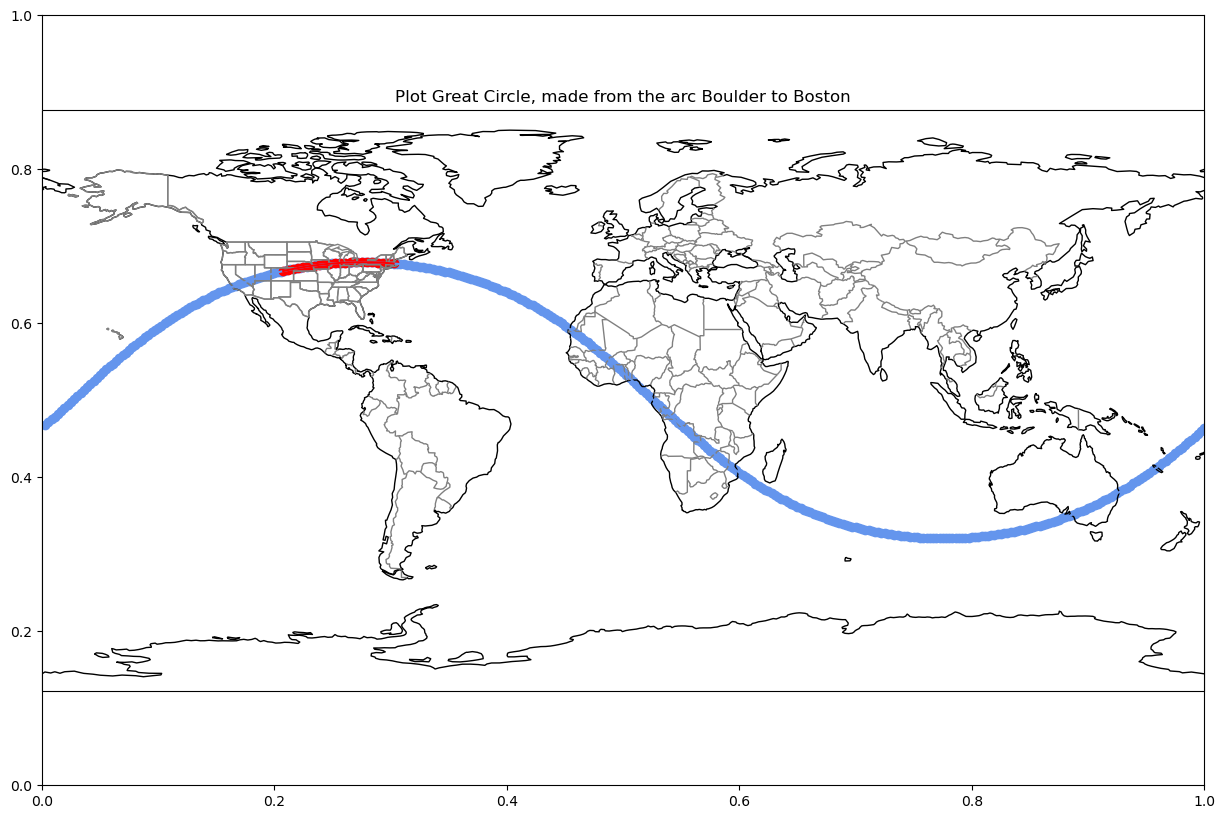

In [98]:
start_pt = "boulder"
end_pt = "boston"
n_pts = 360 # number of points along the longitude (resolution for 360 is one point for each 1 degree)
lat_lon_pts = generate_latitude_along_gc(start_pt, end_pt, number_of_lon_pts=n_pts)
plot_coordinate(lat_lon_pts, start_pt, end_pt,
                f"Plot Great Circle, made from the arc {start_pt.title()} to {end_pt.title()}")

How about a longer arc? Let's start at the Arceibo Telescope and move up to Greenwich (the Prime Meridian)

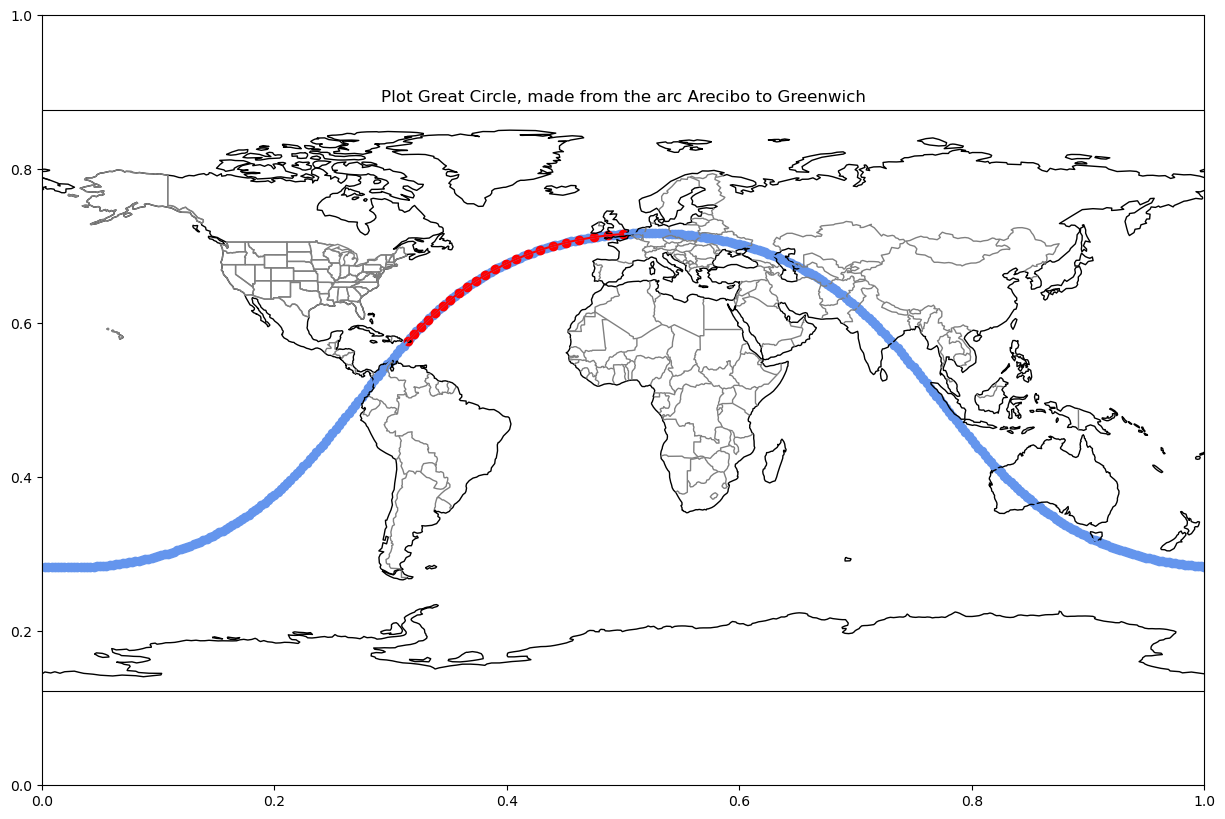

In [99]:
start_pt = "arecibo"
end_pt = "greenwich"
n_pts = 360 # number of points along the longitude (resolution for 360 is one point for each 1 degree)
lat_lon_pts = generate_latitude_along_gc(start_pt, end_pt, number_of_lon_pts=n_pts)
plot_coordinate(lat_lon_pts, start_pt, end_pt,
                f"Plot Great Circle, made from the arc {start_pt.title()} to {end_pt.title()}")

Excellent! And now a very extreme example, starting all the way down in Zambezi and all the way up to Svalbard

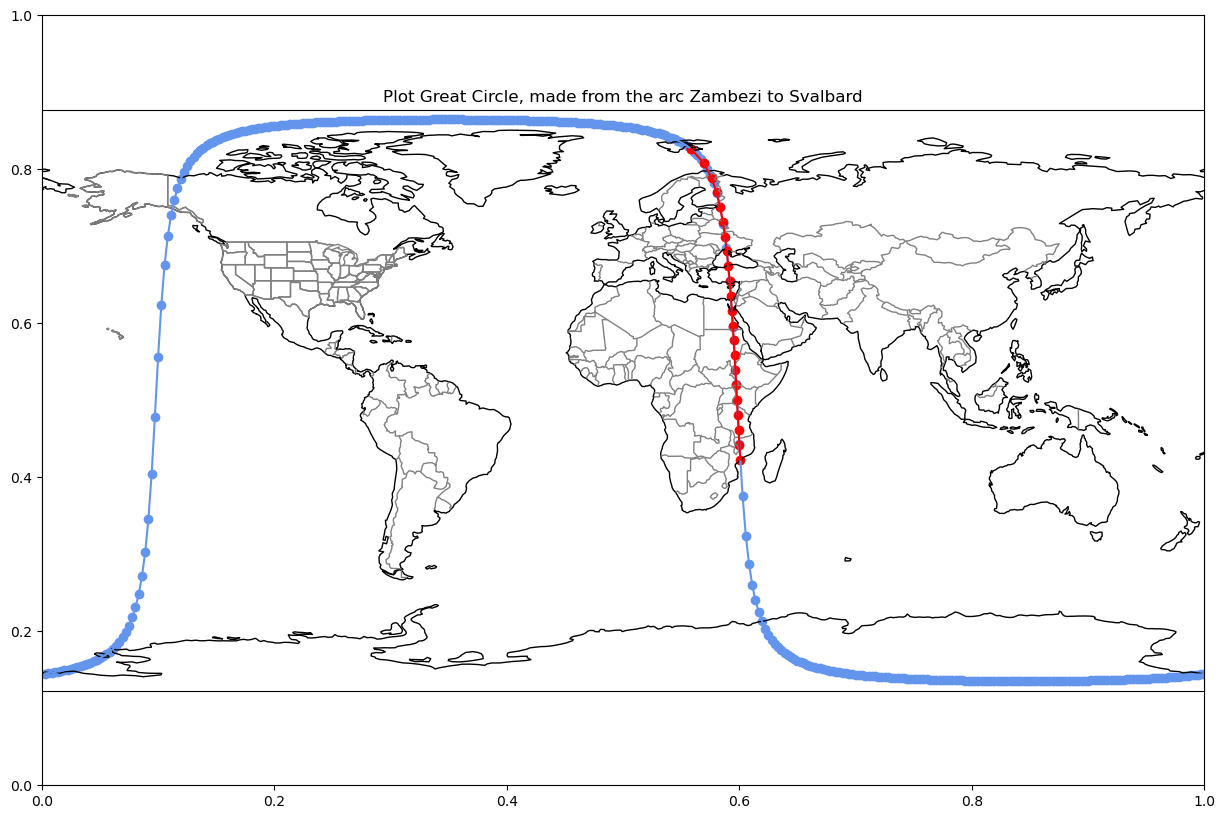

In [100]:
start_pt = "zambezi"
end_pt = "svalbard"
n_pts = 360
lat_lon_pts = generate_latitude_along_gc(start_pt, end_pt, number_of_lon_pts=n_pts)
plot_coordinate(lat_lon_pts, start_pt, end_pt,
                f"Plot Great Circle, made from the arc {start_pt.title()} to {end_pt.title()}")

#### Wait! Wasn't a Great Circle Suppose to be a Line?

You are right! Great circle paths will appear like a straight line that cuts the globe in half. However, on a flat projection, a perfectly straight path will appear curved.

## Determine an Antipodal Point

Imagine you could directly down below your feet through the Earth and all the way to the otherside of the planet. Where would that be? This exactly opposite position is known as a antipodal point. 

The latitude is simple, it is simply the inverse of your current latitude. So, standing at 40 degrees in Boulder, my antipodal latitude will sit at -40 degrees, we can defined this as:

$$\text{antipodal latitude} = -1 * \text{latitude}$$

Antipodal longitude is a little more complicated. This will depend on if you are standing to the East (postive) or West (negative) of the Prime Meridian (0 degrees longitude)

$$\text{anitpodal longitude} = (\text{longitude} + 180) \text{ if longitude} \le 0$$
$$\text{anitpodal longitude} = (\text{longitude} - 180) \text{ if longitude} \gt 0$$

In [107]:
def antipodal(start_point=None):
    # return the antipodal (latitude/longitude) point from a starting position
    anti_lat = -1 * location_df.loc[start_point, "latitude"]
    ref_lon = location_df.loc[start_point, "longitude"]
    if ref_lon > 0:
        anti_lon = ref_lon - 180
    else:
        anti_lon = ref_lon + 180
    return (float(anti_lat), float(anti_lon))

In [108]:
def is_antipodal(start_point=None, end_point=None):
    # return true is a point is antipodal from another point
    lon1 = np.deg2rad(location_df.loc[start_point, "longitude"])
    lat1 = np.deg2rad(location_df.loc[start_point, "latitude"])
    lon2 = np.deg2rad(location_df.loc[end_point, "longitude"])
    lat2 = np.deg2rad(location_df.loc[end_point, "latitude"])
    return lat1 + lat2 == 0 and abs(lon1-lon2) == np.pi

[See for yourself on this antipodes map](https://www.antipodesmap.com/), but we can also plot this in Python.

In [109]:
def plot_antipodal(start_point=None):
    # Set up world map plot
    fig = plt.subplots(figsize=(15, 10))
    projection_map = ccrs.PlateCarree()
    ax = plt.axes(projection=projection_map)
    lon_west, lon_east, lat_south, lat_north = -180, 180, -90, 90
    ax.set_extent([lon_west, lon_east, lat_south, lat_north], crs=projection_map)
    ax.coastlines(color="black")
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor="grey")
        
    # Plot Start point (in blue)
    plt.scatter(location_df.loc[start_point, "longitude"],
                location_df.loc[start_point, "latitude"],
                s=100, c="cornflowerblue", label=start_point.title())

    # Plot Antipodal Point (in red)
    antipodal_point = antipodal(start_point)
    plt.scatter(antipodal_point[1], antipodal_point[0], s=100, c="red", label="Antipodal")
    
    # Setup Axis Limits and Title/Labels
    plt.title(f"{start_point.title()} and Antipodal Point {antipodal_point}")
    plt.legend(loc="lower right")
    plt.show()

Let's see how this looks. Where does the antipodal point from Boulder lie?

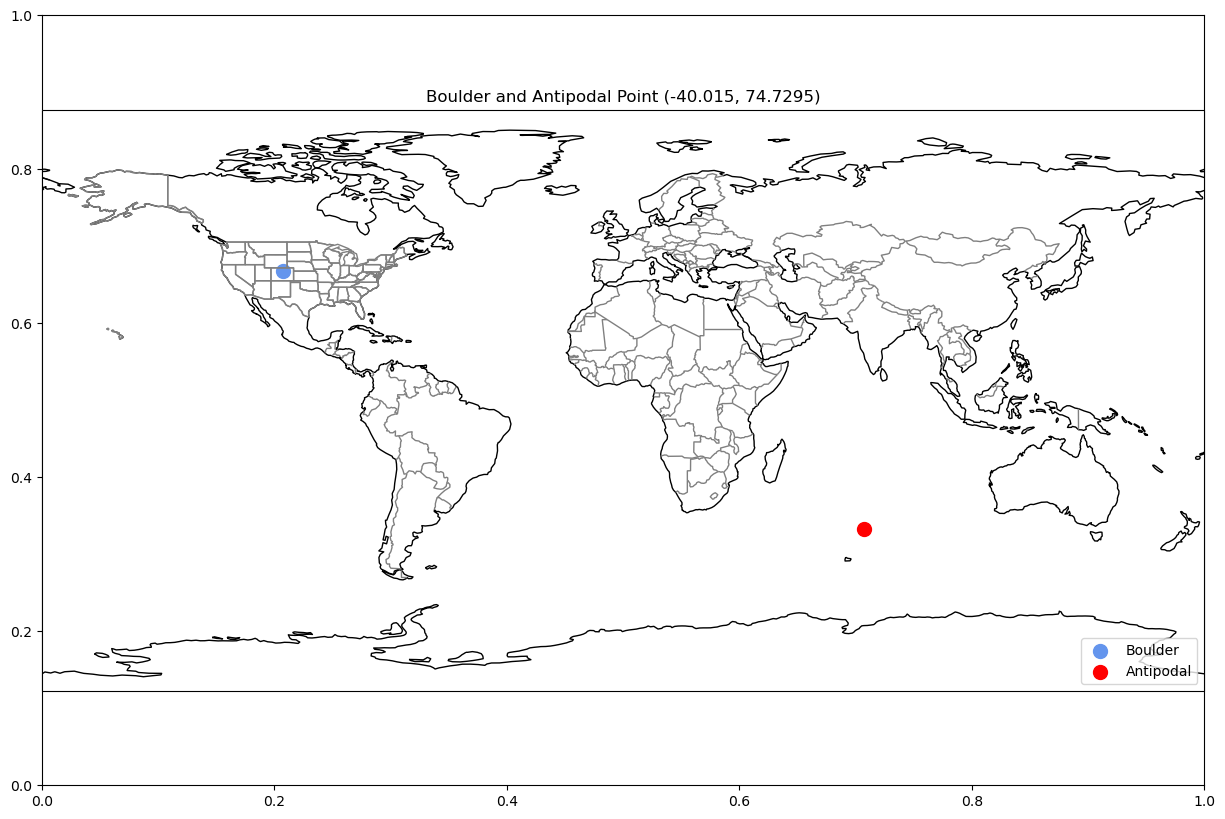

In [111]:
plot_antipodal("boulder")

Ah, the middle of the ocean. What about Svalbard?

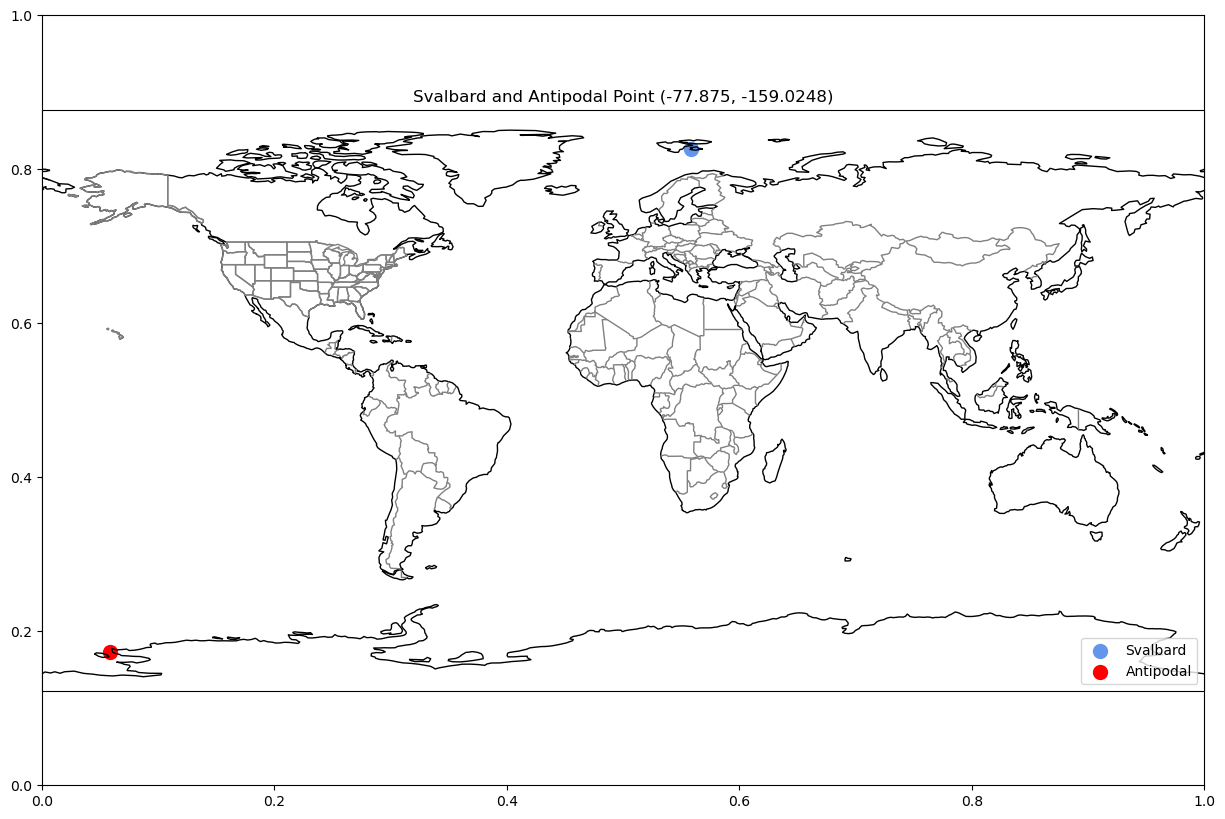

In [112]:
plot_antipodal("svalbard")

Just off the coast of Antartica! And the city of Cairo?

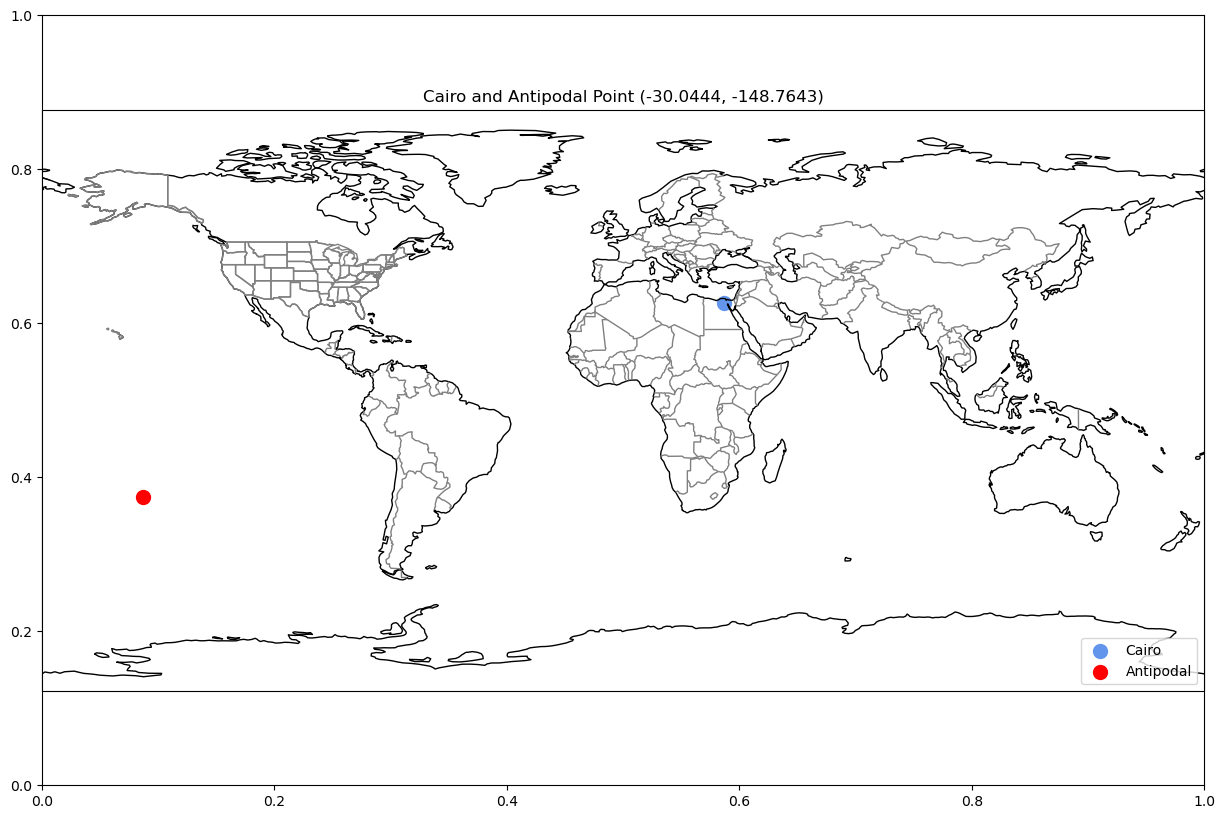

In [113]:
plot_antipodal("cairo")

We are back in the ocean, but that isn't strange. The Earth is mostly water, so don't be suprised if the point on the opposite of the globe from you is lying in the middle of the ocean.

---

## Summary

This notebook covered how to generate and plot great circle arcs and paths with just a starting and ending position. This also included how to calculate the bearing of a great circle arc as well interpolating along the great circle and even how to find the antipodal point to any point on the globe. You were able to see how the difference between treating the Earth as a sphere or as an ellipsoid impacts the final precision.


### What's next?

With a great circle arc defined, it's time to start using the great circle arc as part of a large question. Next, we will determine if a third point is along the arc or at what distance it sits from the great circle arc and path.

## Resources and references

- [Ed Williams "Avitation Formulary"](https://edwilliams.org/avform147.htm)
- [Movable Type Scripts](https://www.movable-type.co.uk/scripts/latlong.html)